In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from des_helpers import dpa_select_function

# Load preprocessed data
trace_df = pd.read_csv("des_extension_data.csv")
plaintexts = trace_df['Plaintext'].to_numpy()
powers = trace_df['Power'].to_numpy()

### The following calculates the empirical success rate of the DOM attack using DPA it takes about 5 minutes to run on my machine.

If you want to regenerate the figure at the bottom you can use the emprical_sr.pkl file.

In [35]:
from joblib import Parallel, delayed

kc = 4

# Number of measurements
n_measurements = range(10, 1001, 10)

sr_sets = {
    "SR_1": (kc, [0]),
    "SR_2": (kc, [0,1]),
    "SR_8": (kc, [0,1,2,3,5,6,7,8]), # skip 4 since it is kc
    "SR_63": (kc, [k for k in range(64) if k != kc])
}

select_outputs_on_key = []
for i in range(64):
    select_outputs_on_key.append(np.array([dpa_select_function(pt, i) for pt in plaintexts]))

def calc_doms(keys, indexes):
    doms = {}
    for key in keys:
        sel_values = select_outputs_on_key[key][indexes]
        mask0 = sel_values == 0
        mask1 = sel_values == 1
        group0_powers = powers[indexes][mask0]
        group1_powers = powers[indexes][mask1]
        avg_group0 = np.mean(group0_powers) if group0_powers.size > 0 else 0
        avg_group1 = np.mean(group1_powers) if group1_powers.size > 0 else 0
        doms[key] = avg_group1 - avg_group0
    return doms

def trial_success(sample_indexes, kc, k_guesses):
    doms = calc_doms([kc] + k_guesses, sample_indexes)
    kc_dom = doms[kc]
    for k in k_guesses:
        if kc_dom < doms[k]:
            return False
    return True

trails = 1000
sr_data = {}

for sr in sr_sets:
    sr_data[sr] = []
    kc = sr_sets[sr][0]
    k_guesses = sr_sets[sr][1]
    
    for n in n_measurements:
        samples = [trace_df.sample(n).index for _ in range(trails)]
        results = Parallel(n_jobs=4)(
            delayed(trial_success)(sample, kc, k_guesses) for sample in samples
        )
        success_rate = sum(results) / trails
        sr_data[sr].append(success_rate)
        print(f"{sr}: num measures {n}")

SR_1: num measures 10
SR_1: num measures 20
SR_1: num measures 30
SR_1: num measures 40
SR_1: num measures 50
SR_1: num measures 60
SR_1: num measures 70
SR_1: num measures 80
SR_1: num measures 90
SR_1: num measures 100
SR_1: num measures 110
SR_1: num measures 120
SR_1: num measures 130
SR_1: num measures 140
SR_1: num measures 150
SR_1: num measures 160
SR_1: num measures 170
SR_1: num measures 180
SR_1: num measures 190
SR_1: num measures 200
SR_1: num measures 210
SR_1: num measures 220
SR_1: num measures 230
SR_1: num measures 240
SR_1: num measures 250
SR_1: num measures 260
SR_1: num measures 270
SR_1: num measures 280
SR_1: num measures 290
SR_1: num measures 300
SR_1: num measures 310
SR_1: num measures 320
SR_1: num measures 330
SR_1: num measures 340
SR_1: num measures 350
SR_1: num measures 360
SR_1: num measures 370
SR_1: num measures 380
SR_1: num measures 390
SR_1: num measures 400
SR_1: num measures 410
SR_1: num measures 420
SR_1: num measures 430
SR_1: num measures 4

In [36]:
import pickle
# Save the arrays using pickle
with open("emprical_sr.pkl", "wb") as f:
    pickle.dump(sr_data, f)
print(f"Confusion data saved to emprical_sr.pkl")

Confusion data saved to emprical_sr.pkl


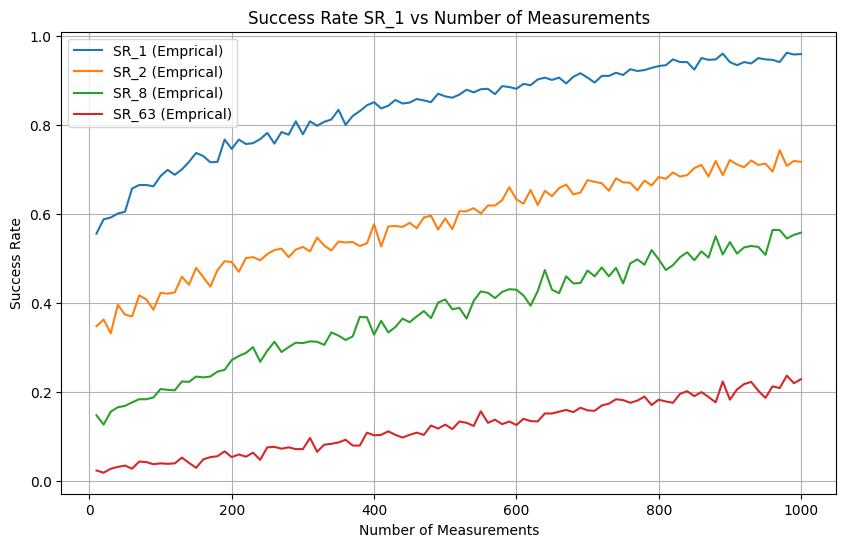

In [37]:
# Plot SR_63
import pickle
import matplotlib.pyplot as plt

with open("emprical_sr.pkl", "rb") as f:
    data = pickle.load(f)

# Number of measurements
n_measurements = range(10, 1001, 10)

sr_sets = {
    "SR_1": (kc, [0]),
    "SR_2": (kc, [0,1]),
    "SR_8": (kc, [0,1,2,3,5,6,7,8]), # skip 4 since it is kc
    "SR_63": (kc, [k for k in range(64) if k != kc])
}

plt.figure(figsize=(10, 6))
for sr in sr_sets:
    plt.plot(n_measurements, sr_data[sr], label=f"{sr} (Emprical)")
plt.xlabel("Number of Measurements")
plt.ylabel("Success Rate")
plt.title("Success Rate SR_1 vs Number of Measurements")
plt.legend()
plt.grid()
plt.show()